In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#!git clone https://github.com/matterport/Mask_RCNN.git

import glob
import os

os.chdir("/content/drive/My Drive/Edgify/Parking Space Finder/Automatic-Parking-Management-master/Automatic-Parking-Management-master")
# Directory of images to run detection on
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

Mounted at /content/drive
/content/drive/My Drive/Edgify/Parking Space Finder/Automatic-Parking-Management-master/Automatic-Parking-Management-master


In [ ]:
from google.colab.patches import cv2_imshow


In [ ]:
"""
Instructions: Escape key to termintae the program. Please press mutiple times if it doesn't work.
Press u to jump 500 frames and J for 1000
Values in the dictionary can be modified:-
1. show_ids: turn id of parking areas on or off
2. save_video: to save the video generated by program
3. text_overlay: displaying the frame count at the left top corner
4. motion_detection: turn on of off, motion detection
5. pedestrian detection: slow due to use of opencv HOG inbuilt function
6. min_area_motion_contour: min area to take for motion tracking
7. start_frame: from which frame number to start
8. park_laplacian_th: set threshold vsslues for different parkings
"""



import yaml
import numpy as np
import cv2

# path references
fn = "Train-Santa-Monica-1.mp4" #3
#fn = "datasets\parkinglot_1_720p.mp4"
#fn = "datasets\street_high_360p.mp4"
fn_yaml = "Khare_yml_01.yml"
fn_out =  "Khare_outputvideo_01.avi"
cascade_src = 'Khare_classifier_02.xml'
car_cascade = cv2.CascadeClassifier(cascade_src)
global_str = "Last change at: "
change_pos = 0.00
dict =  {
        'text_overlay': True,
        'parking_overlay': True,
        'parking_id_overlay': True,
        'parking_detection': True,
        'motion_detection': True,
        'pedestrian_detection': False, # takes a lot of processing power
        'min_area_motion_contour': 500, # area given to detect motion
        'park_laplacian_th': 2.8, 
        'park_sec_to_wait': 0, # 4   wait time for changing the status of a region
        'start_frame': 0, # begin frame from specific frame number 
        'show_ids': True, # shows id on each region
        'classifier_used': True,
        'save_video': False
        }

# Set from video
cap = cv2.VideoCapture(fn)
video_info = {  'fps':    cap.get(cv2.CAP_PROP_FPS),
                'width':  int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)*0.6),
                'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)*0.6),
                'fourcc': cap.get(cv2.CAP_PROP_FOURCC),
                'num_of_frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT))}

cap.set(cv2.CAP_PROP_POS_FRAMES, dict['start_frame']) # jump to frame number specified

def run_classifier(img, id):
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cars = car_cascade.detectMultiScale(img, 1.1, 1)
    if cars == ():
        return False
    else:
        # parking_status[id] = False
        return True

# Define the codec and create VideoWriter object
if dict['save_video']:
    fourcc = cv2.VideoWriter_fourcc('X','V','I','D') # options: ('P','I','M','1'), ('D','I','V','X'), ('M','J','P','G'), ('X','V','I','D')
    out = cv2.VideoWriter(fn_out, -1, 25.0,(video_info['width'], video_info['height']))

# initialize the HOG descriptor/person detector. Take a lot of processing power.
if dict['pedestrian_detection']:
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    # Use Background subtraction
if dict['motion_detection']:
    fgbg = cv2.createBackgroundSubtractorMOG2(history=300, varThreshold=16, detectShadows=True)

# Read YAML data (parking space polygons)
with open(fn_yaml, 'r') as stream:
    parking_data = yaml.load(stream)
parking_contours = []
parking_bounding_rects = []
parking_mask = []
parking_data_motion = []
if parking_data != None:
    for park in parking_data:
        points = np.array(park['points'])
        rect = cv2.boundingRect(points)
        points_shifted = points.copy()
        points_shifted[:,0] = points[:,0] - rect[0] # shift contour to region of interest
        points_shifted[:,1] = points[:,1] - rect[1]
        parking_contours.append(points)
        parking_bounding_rects.append(rect)
        mask = cv2.drawContours(np.zeros((rect[3], rect[2]), dtype=np.uint8), [points_shifted], contourIdx=-1,
                                    color=255, thickness=-1, lineType=cv2.LINE_8)
        mask = mask==255
        parking_mask.append(mask)

kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)) # morphological kernel
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT,(5,19))
if parking_data != None:
    parking_status = [False]*len(parking_data)
    parking_buffer = [None]*len(parking_data)
# bw = ()
def print_parkIDs(park, coor_points, frame_rev):
    moments = cv2.moments(coor_points)
    centroid = (int(moments['m10']/moments['m00'])-3, int(moments['m01']/moments['m00'])+3)
    # putting numbers on marked regions
    cv2.putText(frame_rev, str(park['id']), (centroid[0]+1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), (centroid[0]-1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), (centroid[0]+1, centroid[1]-1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), (centroid[0]-1, centroid[1]+1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(frame_rev, str(park['id']), centroid, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
    
while(cap.isOpened()):
    video_cur_pos = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0 # Current position of the video file in seconds
    video_cur_frame = cap.get(cv2.CAP_PROP_POS_FRAMES) # Index of the frame to be decoded/captured next
    ret, frame_initial = cap.read()
    if ret == True:
        frame = cv2.resize(frame_initial, None, fx=0.6, fy=0.6)
    if ret == False:
        print("Video ended")
        break

    # Background Subtraction
    frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
    # frame_blur = frame_blur[150:1000, 100:1800]
    frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
    frame_out = frame.copy()

    # Drawing the Overlay. Text overlay at the left corner of screen
    if dict['text_overlay']:
        str_on_frame = "%d/%d" % (video_cur_frame, video_info['num_of_frames'])
        cv2.putText(frame_out, str_on_frame, (5,30), cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, (0,255,255), 2, cv2.LINE_AA)
        cv2.putText(frame_out,global_str + str(round(change_pos,2)) + 'sec', (5, 60), cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, (255, 0, 0), 2, cv2.LINE_AA)

    # motion detection for all objects
    if dict['motion_detection']:
        # frame_blur = frame_blur[380:420, 240:470]
        # cv2.imshow('dss', frame_blur)
        fgmask = fgbg.apply(frame_blur)
        bw = np.uint8(fgmask==255)*255
        bw = cv2.erode(bw, kernel_erode, iterations=1)
        bw = cv2.dilate(bw, kernel_dilate, iterations=1)
        # cv2.imshow('dss',bw)
        # cv2.imwrite("frame%d.jpg" % co, bw)
        (cnts, _) = cv2.findContours(bw.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # loop over the contours
        for c in cnts:
            # print(cv2.contourArea(c))
            # if the contour is too small, we ignore it
            if cv2.contourArea(c) < dict['min_area_motion_contour']:
                continue
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame_out, (x, y), (x + w, y + h), (255, 0, 0), 1)

    # detecting cars and vacant spaces
    if dict['parking_detection']:
        for ind, park in enumerate(parking_data):
            points = np.array(park['points'])
            rect = parking_bounding_rects[ind]
            roi_gray = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] # crop roi for faster calcluation

            laplacian = cv2.Laplacian(roi_gray, cv2.CV_64F)
            # cv2.imshow('oir', laplacian)
            points[:,0] = points[:,0] - rect[0] # shift contour to roi
            points[:,1] = points[:,1] - rect[1]
            delta = np.mean(np.abs(laplacian * parking_mask[ind]))
            # if(delta<2.5):
                # print("ind, del", ind, delta)
            status = delta < dict['park_laplacian_th']
            # If detected a change in parking status, save the current time
            if status != parking_status[ind] and parking_buffer[ind]==None:
                parking_buffer[ind] = video_cur_pos
                change_pos = video_cur_pos
                # print("state ", ind,delta)
                # applying classifier in case a change is detected in the status of area
                # if dict['classifier_used']:
                #     classifier_result = run_classifier(roi_gray)
                #     if classifier_result:
                #         print(classifier_result)
            # If status is still different than the one saved and counter is open
            elif status != parking_status[ind] and parking_buffer[ind]!=None:
                if video_cur_pos - parking_buffer[ind] > dict['park_sec_to_wait']:
                    parking_status[ind] = status
                    parking_buffer[ind] = None
            # If status is still same and counter is open
            elif status == parking_status[ind] and parking_buffer[ind]!=None:
                parking_buffer[ind] = None

    # changing the color on the basis on status change occured in the above section and putting numbers on areas
    if dict['parking_overlay']:
        for ind, park in enumerate(parking_data):
            points = np.array(park['points'])
            if parking_status[ind]:
                color = (0,255,0)
                rect = parking_bounding_rects[ind]
                roi_gray_ov = frame_gray[rect[1]:(rect[1] + rect[3]),
                               rect[0]:(rect[0] + rect[2])]  # crop roi for faster calcluation
                res = run_classifier(roi_gray_ov, ind)
                if res:
                    parking_data_motion.append(parking_data[ind])
                    # del parking_data[ind]
                    color = (0,0,255)
            else:
                color = (0,0,255)
            
            cv2.drawContours(frame_out, [points], contourIdx=-1,
                                 color=color, thickness=2, lineType=cv2.LINE_8)
            if dict['show_ids']:
                    print_parkIDs(park, points, frame_out)
            
            

    if parking_data_motion != []:
        for index, park_coord in enumerate(parking_data_motion):
            points = np.array(park_coord['points'])
            color = (0, 0, 255)
            recta = parking_bounding_rects[ind]
            roi_gray1 = frame_gray[recta[1]:(recta[1] + recta[3]),
                            recta[0]:(recta[0] + recta[2])]  # crop roi for faster calcluation
            # laplacian = cv2.Laplacian(roi_gray, cv2.CV_64F)
            # delta2 = np.mean(np.abs(laplacian * parking_mask[ind]))
            # state = delta2<1
            # classifier_result = run_classifier(roi_gray1, index)
            # cv2.imshow('dsd', roi_gray1)
            fgbg1 = cv2.createBackgroundSubtractorMOG2(history=300, varThreshold=16, detectShadows=True)
            roi_gray1_blur = cv2.GaussianBlur(roi_gray1.copy(), (5, 5), 3)
            # cv2.imshow('sd', roi_gray1_blur)
            fgmask1 = fgbg1.apply(roi_gray1_blur)
            bw1 = np.uint8(fgmask1 == 255) * 255
            bw1 = cv2.erode(bw1, kernel_erode, iterations=1)
            bw1 = cv2.dilate(bw1, kernel_dilate, iterations=1)
            # cv2.imshow('sd', bw1)
            # cv2.imwrite("frame%d.jpg" % co, bw)
            (cnts1, _) = cv2.findContours(bw1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            # loop over the contours
            for c in cnts1:
                print(cv2.contourArea(c))
                # if the contour is too small, we ignore it
                if cv2.contourArea(c) < 4:
                    continue
                (x, y, w, h) = cv2.boundingRect(c)
                classifier_result1 = run_classifier(roi_gray1, index)
                if classifier_result1:
                # print(classifier_result)
                    color = (0, 0, 255)  # Red again if car found by classifier
                else:
                    color = (0,255, 0)
            classifier_result1 = run_classifier(roi_gray1, index)
            if classifier_result1:
                # print(classifier_result)
                color = (0, 0, 255)  # Red again if car found by classifier
            else:
                color = (0, 255, 0)
            cv2.drawContours(frame_out, [points], contourIdx=-1,
                                 color=color, thickness=2, lineType=cv2.LINE_8)

    if dict['pedestrian_detection']:
        # detect people in the image. Slows down the program, requires high GPU speed
        (rects, weights) = hog.detectMultiScale(frame, winStride=(4, 4), padding=(8, 8), scale=1.05)
        # draw the  bounding boxes
        for (x, y, w, h) in rects:
            cv2.rectangle(frame_out, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # write the output frames
    if dict['save_video']:
#         if video_cur_frame % 35 == 0: # take every 30 frames
            out.write(frame_out)

    # Display video
    #cv2.imshow('frame', frame_out)
    # cv2.imshow('background mask', bw)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
    elif k == ord('c'):
        cv2.imwrite('frame%d.jpg' % video_cur_frame, frame_out)
    elif k == ord('j'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame+1000) # jump 1000 frames
    elif k == ord('u'):
        cap.set(cv2.CAP_PROP_POS_FRAMES, video_cur_frame + 500)  # jump 500 frames
    if cv2.waitKey(33) == 27:
        break

cv2.waitKey(0)
cap.release()
if dict['save_video']: out.release()
cv2.destroyAllWindows()   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Video ended


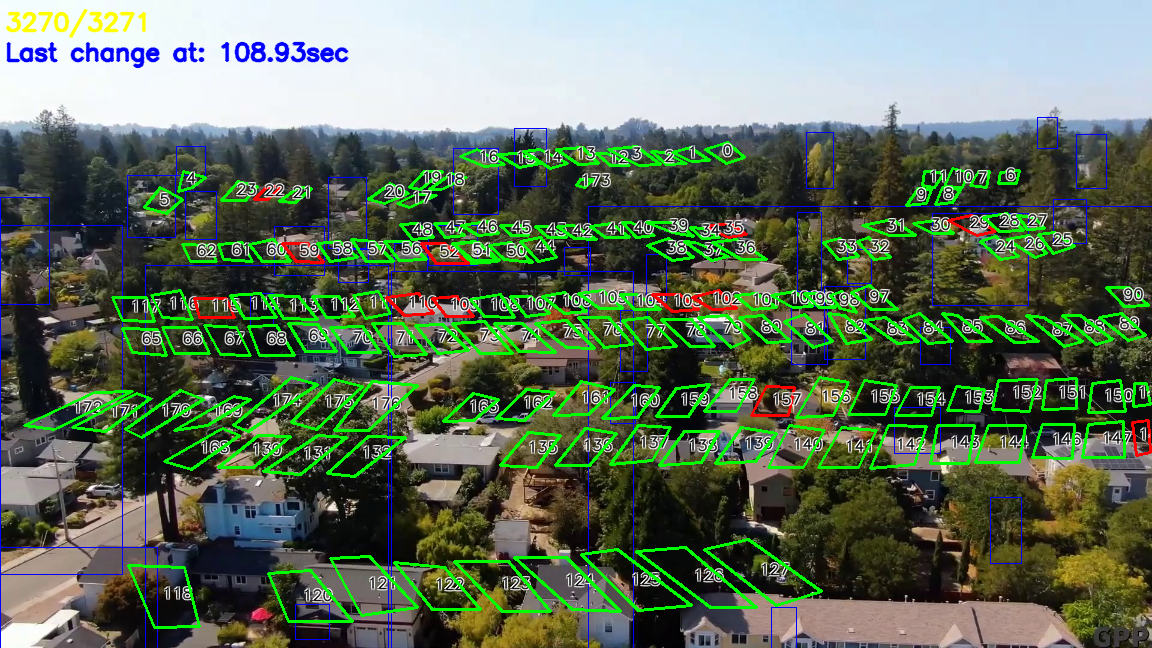

In [ ]:
cv2_imshow(frame_out)

In [ ]:
# Classifier demonstration on different videos:
from imutils.object_detection import non_max_suppression

def perform_classification(video_src, cascade_src):
    cap = cv2.VideoCapture(video_src)
    car_cascade = cv2.CascadeClassifier(cascade_src)
    while True:
        ret, img = cap.read()
        if (type(img) == type(None)):
            print('Video not found')
            break
        image_scaled = cv2.resize(img, None, fx=0.6, fy=0.6)
        gray = cv2.cvtColor(image_scaled, cv2.COLOR_BGR2GRAY)
        cars = car_cascade.detectMultiScale(gray, 1.1, 1) #1.1, 1
        cars = np.array([[x, y, x + w, y + h] for (x, y, w, h) in cars])
        pick = non_max_suppression(cars, probs=None, overlapThresh=0.65)
        for (x, y, w, h) in pick:
            # cv2.rectangle(image_scaled, (x, y), (x + w, y + h), (0 , 255, 255), 2) #bgr
            cv2.rectangle(image_scaled, (x, y), (w,  h), (0, 255, 255), 2)
        cv2.imshow('Press ESC key to finish', image_scaled)

            # press escape key to exit
        if cv2.waitKey(33) == 27:
            break
    print('Execution finished')
    cv2.destroyAllWindows()
    
perform_classification('Khare_testvideo_01.mp4', 'Khare_classifier_01.xml')    # press escape to finish
perform_classification('Khare_testvideo_01.mp4', 'Khare_classifier_02.xml')
perform_classification('Khare_testvideo_02.avi', 'Khare_classifier_01.xml')    # M6 highway Britain
perform_classification('Khare_testvideo_02.avi', 'Khare_classifier_02.xml')  

DisabledFunctionError: ignored

In [ ]:
# measuring accuracy of classifier. Frames are taken in different light conditions (morning, afternoon and evening)
import Khare_utility_01 as util

util.get_acc('Khare_classifier_01.xml')
util.get_acc('Khare_classifier_02.xml')

In [ ]:
# press escape to finish doing real time boxing.
# Program marks the polygons in the figure when it gets 4 double clicks
import cv2
import yaml
import numpy as np

refPt = []
cropping = False
data = []
file_path = 'Khare_yml_02.yml'
img = cv2.imread('Khare_frame_02.png')

def yaml_loader(file_path):
    with open(file_path, "r") as file_descr:
        data = yaml.load(file_descr)
        return data


def yaml_dump(file_path, data):
    with open(file_path, "a") as file_descr:
        yaml.dump(data, file_descr)


def yaml_dump_write(file_path, data):
    with open(file_path, "w") as file_descr:
        yaml.dump(data, file_descr)


def click_and_crop(event, x, y, flags, param):
    current_pt = {'id': 0, 'points': []}
    # grab references to the global variables
    global refPt, cropping
    if event == cv2.EVENT_LBUTTONDBLCLK:
        refPt.append((x, y))
        cropping = False
    if len(refPt) == 4:
        if data == []:
            if yaml_loader(file_path) != None:
                data_already = len(yaml_loader(file_path))
            else:
                data_already = 0
        else:
            if yaml_loader(file_path) != None:
                data_already = len(data) + len(yaml_loader(file_path))
            else:
                data_already = len(data) 
        
        cv2.line(image, refPt[0], refPt[1], (0, 255, 0), 1)
        cv2.line(image, refPt[1], refPt[2], (0, 255, 0), 1)
        cv2.line(image, refPt[2], refPt[3], (0, 255, 0), 1)
        cv2.line(image, refPt[3], refPt[0], (0, 255, 0), 1)

        temp_lst1 = list(refPt[2])
        temp_lst2 = list(refPt[3])
        temp_lst3 = list(refPt[0])
        temp_lst4 = list(refPt[1])

        current_pt['points'] = [temp_lst1, temp_lst2, temp_lst3, temp_lst4]
        current_pt['id'] = data_already
        data.append(current_pt)
        # data_already+=1
        refPt = []
image = cv2.resize(img, None, fx=0.6, fy=0.6)
clone = image.copy()
cv2.namedWindow("Double click to mark points")
cv2.imshow("Double click to mark points", image)
cv2.setMouseCallback("Double click to mark points", click_and_crop)

# keep looping until the 'q' key is pressed
while True:
    # display the image and wait for a keypress
    cv2.imshow("Double click to mark points", image)
    key = cv2.waitKey(1) & 0xFF
    if cv2.waitKey(33) == 27:
        break
       
# data list into yaml file
if data != []:
    yaml_dump(file_path, data)
cv2.destroyAllWindows() #important to prevent window from becoming inresponsive

In [ ]:
# Program to demonstrate the calculation of threshold value for a given parking arrangement
import statistics
import cv2
import yaml
import numpy as np
        
sum_up = 0.0
delta_list = []
frame = cv2.imread('Khare_frame_02.png') #
parking_bounding_rects = []
parking_mask = []
frame_blur = cv2.GaussianBlur(frame.copy(), (5,5), 3)
frame_gray = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2GRAY)
with open('Khare_yml_03.yml', 'r') as stream:
    parking_data = yaml.load(stream)
    
if parking_data != None:
    for park in parking_data:
        points = np.array(park['points'])
        rect = cv2.boundingRect(points)
        points_shifted = points.copy()
        points_shifted[:,0] = points[:,0] - rect[0] # shift contour to region of interest
        points_shifted[:,1] = points[:,1] - rect[1]
        
        parking_bounding_rects.append(rect)
        mask = cv2.drawContours(np.zeros((rect[3], rect[2]), dtype=np.uint8), [points_shifted], contourIdx=-1,
                                    color=255, thickness=-1, lineType=cv2.LINE_8)
        mask = mask==255
        parking_mask.append(mask)

for ind, park in enumerate(parking_data):
        points = np.array(park['points'])
        rect = parking_bounding_rects[ind]
        roi_gray = frame_gray[rect[1]:(rect[1]+rect[3]), rect[0]:(rect[0]+rect[2])] # crop roi for faster calcluation

        laplacian = cv2.Laplacian(roi_gray, cv2.CV_64F)
        points[:,0] = points[:,0] - rect[0] # shift contour to roi
        points[:,1] = points[:,1] - rect[1]
        delta = np.mean(np.abs(laplacian * parking_mask[ind]))
        if(delta > 1.8):    # ignoring empty spaces
            delta_list.append(delta)
            # print(delta)
        sum_up = sum_up + delta
        
avg = sum_up/len(parking_data)
med = statistics.median(delta_list)
print("mean: ", avg)
print("median: ", med)